# Testing SQI results and clustering methods for SQI values
## the pipeline for this file is as followes:
    1) read the bidmc csv data stores in ./data/bidmc_csv
    2) denoise, window both ppg and ecg signal pairs for each subject
    3) comupte SQI values for each window(SNR, Kurtosis, skew)
    4) Cluster using DBScan, leave only 2 clusters (most dense cluster - 1, Rest - 0)
    5) pefrom ecg reconstrucion from ppg on the bidmc data
    6) plot several comparisons based on clustering on the reconstrucion

# Initialize Functions, Load Data

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.stats import kurtosis, skew
import pywt
from tqdm import tqdm
from scipy.signal import butter, filtfilt

# ---- PARAMETERS ----
FS = 125
WINDOW_SIZE_SEC = 8.192
STEP_SIZE_SEC = 2.048

# ---- BASELINE REMOVAL ----
def remove_baseline_median(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def remove_baseline_wavelet(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    return pywt.waverec(coeffs, wavelet)[:len(signal)]

# ---- WINDOWING ----
def create_windows(signal, win_size, step_size):
    return np.array([
        signal[start:start + win_size]
        for start in range(0, len(signal) - win_size + 1, step_size)
    ])

# ---- LOAD DATA ----
def load_signals(file_path):
    df = pd.read_csv(file_path)
    df.columns = [c.strip() for c in df.columns]
    if 'II' not in df.columns or 'PLETH' not in df.columns:
        return None, None
    ecg = df['II'].values
    ppg = df['PLETH'].values
    return ecg, ppg

# ---- SQIs ----
def compute_sqi_snr(ecg_window):
    ecg_abs = np.abs(ecg_window)
    var_signal = np.var(ecg_abs)
    var_noise = np.var(ecg_window)
    return 10 * np.log10(var_signal / (var_noise + 1e-8))  # dB

def compute_sqi_kur(ecg_window):
    return kurtosis(ecg_window)

def compute_sqi_hos(ecg_window):
    return {
        "SQIskew": skew(ecg_window),
        "SQIkur": kurtosis(ecg_window)
    }
def compute_rms_snr(ecg_window, fs=125):
    def bandpass(x, fs, low=0.5, high=40.0):
        nyq = fs / 2
        b, a = butter(3, [low/nyq, high/nyq], btype='band')
        return filtfilt(b, a, x)

    filtered = bandpass(ecg_window, fs)
    noise = ecg_window - filtered
    signal_power = np.mean(filtered**2)
    noise_power = np.mean(noise**2) + 1e-8
    return 10 * np.log10(signal_power / noise_power)

# ---- WINDOW CLASSIFICATION ----
def classify_window_by_sqi(w):
    std = np.std(w)
    if std < 0.001:
        return "Dead"
    sqi = compute_sqi_snr(w)
    if sqi < 6:  # Adjust as needed
        return "Noisy"
    return "Clean"

# ---- PER-SUBJECT ANALYSIS ----
def analyze_subject(subject_id, file_path):
    ecg, ppg = load_signals(file_path)
    if ecg is None or ppg is None:
        return None

    ecg = remove_baseline_wavelet(ecg)
    ppg = remove_baseline_median(ppg, FS)

    win_size = int(WINDOW_SIZE_SEC * FS)
    step_size = int(STEP_SIZE_SEC * FS)
    ecg_windows = create_windows(ecg, win_size, step_size)
    if len(ecg_windows) == 0:
        return None

    snrs = []
    clean, noisy, dead = 0, 0, 0
    window_metrics = []

    for idx, w in enumerate(ecg_windows):
        classification = classify_window_by_sqi(w)

        if classification == "Dead":
            dead += 1
            continue
        elif classification == "Noisy":
            noisy += 1
        else:
            clean += 1

        sqi_snr = compute_sqi_snr(w)
        hos = compute_sqi_hos(w)
        rms_snr = compute_rms_snr(w)

        snrs.append(sqi_snr)
        window_metrics.append({
            "Subject": subject_id,
            "Window": idx,
            "Classification": classification,
            "SQIsnr": sqi_snr,
            "SQIrms": rms_snr,
            "SQIkur": hos["SQIkur"],
            "SQIskew": hos["SQIskew"]
        })

    subject_summary = {
        "Subject": subject_id,
        "Total Windows": len(ecg_windows),
        "Clean Windows": clean,
        "Noisy Windows": noisy,
        "Dead Windows": dead,
        "Mean SNR": np.mean(snrs) if snrs else np.nan,
        "Std SNR": np.std(snrs) if snrs else np.nan
    }

    return subject_summary, window_metrics

# ---- MAIN PROCESSING ----
subject_results = []
all_window_metrics = []

for i in tqdm(range(1, 54)):  # 53 subjects
    file_idx = f"{i:02d}"
    file_path = f"data/bidmc_csv/bidmc_{file_idx}_Signals.csv"
    if os.path.exists(file_path):
        result = analyze_subject(file_idx, file_path)
        if result is not None:
            subject_summary, window_metrics = result
            subject_results.append(subject_summary)
            all_window_metrics.extend(window_metrics)

# ---- OUTPUT RESULTS ----
df_results = pd.DataFrame(subject_results)
df_windows = pd.DataFrame(all_window_metrics)

# Save both
df_results.to_csv("quality_summary.csv", index=False)
df_windows.to_csv("window_metrics.csv", index=False)

# Show previews
print(df_results.head(10))
print(df_windows.head(10))


100%|██████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 115359.68it/s]

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


# Cluster the windows based on the 3 SQI metrics using DBScan

### we can see that clustering catches both noise and pathologies alike


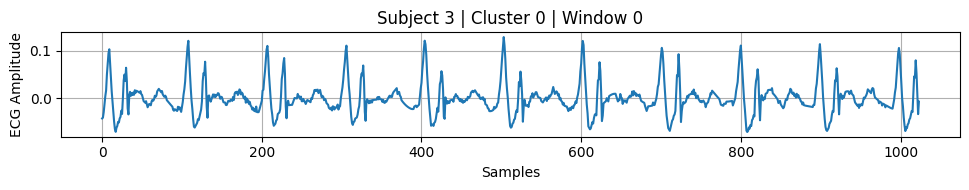

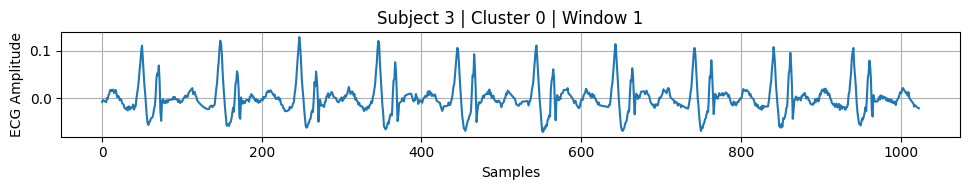

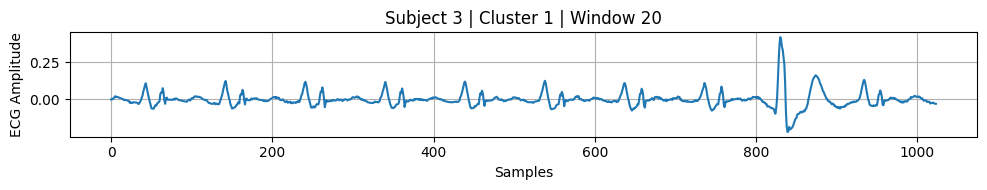

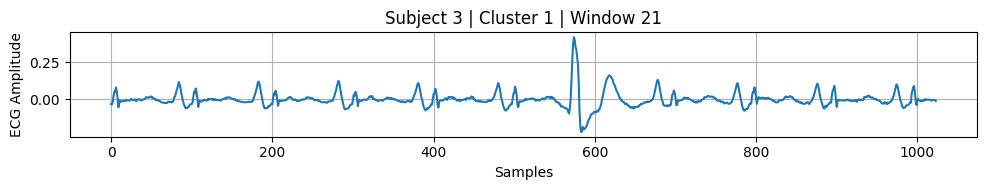

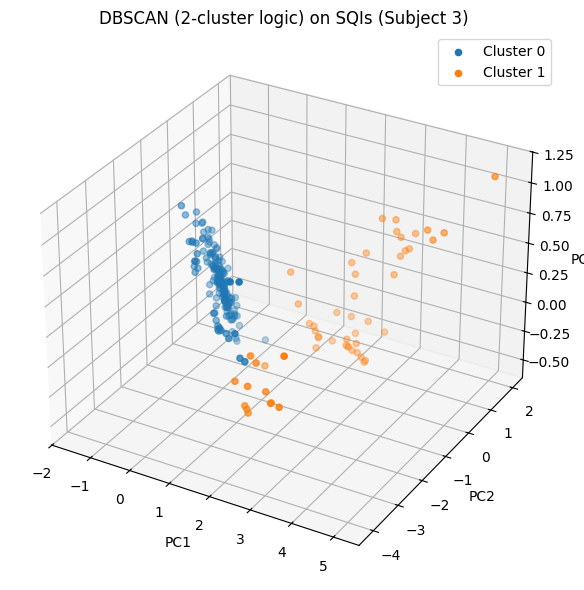

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- PARAMETERS ----
subject_id = 3
fs = 125
win_sec = 8.192
step_sec = 2.048
data_path = f"data/bidmc_csv/bidmc_{subject_id:02d}_Signals.csv"
df_windows = pd.read_csv("window_metrics.csv")

# ---- Load signal ----
df_signal = pd.read_csv(data_path)
df_signal.columns = [c.strip() for c in df_signal.columns]
ecg = df_signal["II"].values
ecg = remove_baseline_wavelet(ecg)
# ---- Windowing ----
def create_windows(signal, win_size, step_size):
    return np.array([
        signal[start:start + win_size]
        for start in range(0, len(signal) - win_size + 1, step_size)
    ])
win_size = int(win_sec * fs)
step_size = int(step_sec * fs)
ecg_windows = create_windows(ecg, win_size, step_size)

# ---- Prepare SQI features ----
df_subj = df_windows[df_windows['Subject'] == subject_id].copy()
features = df_subj[['SQIsnr', 'SQIkur', 'SQIskew']].dropna()
index_map = features.index

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ---- DBSCAN clustering ----
dbscan = DBSCAN(eps=0.8, min_samples=5)
raw_labels = dbscan.fit_predict(X_scaled)

# ---- Force only 2 clusters: Cluster0 vs Others (including noise)
labels = np.where(raw_labels == 0, 0, 1)
df_subj.loc[index_map, 'Cluster'] = labels

# ---- Select and plot 2 example windows per cluster ----
examples_per_cluster = {}
for cluster_id in np.unique(labels):
    cluster_windows = df_subj[df_subj['Cluster'] == cluster_id]
    example_indices = cluster_windows.index[:2]
    examples_per_cluster[cluster_id] = example_indices

for cluster_id, indices in examples_per_cluster.items():
    for idx in indices:
        win_idx = df_subj.loc[idx, 'Window']
        ecg_window = ecg_windows[int(win_idx)]

        plt.figure(figsize=(10, 2))
        plt.plot(ecg_window)
        plt.title(f"Subject {subject_id} | Cluster {cluster_id} | Window {int(win_idx)}")
        plt.xlabel("Samples")
        plt.ylabel("ECG Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ---- Optional: 3D PCA visualization ----
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_plot["Cluster"] = labels

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in np.unique(labels):
    subset = df_plot[df_plot["Cluster"] == cluster_id]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=f"Cluster {cluster_id}")

ax.set_title(f"DBSCAN (2-cluster logic) on SQIs (Subject {subject_id})")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()


# Analysis the Clustering Results

In [29]:
import os
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ---- PARAMETERS ----
DATA_DIR = "bidmc_csv"        # folder containing bidmc_XX_Signals.csv files
N_SUBJECTS = 53               # total number of subjects
FS = 125                      # sampling rate
WINDOW_SIZE_SEC = 8.192
STEP_SIZE_SEC = 2.048

# ---- WINDOWING ----
def create_windows(signal, win_size, step_size):
    return np.array([
        signal[start:start + win_size]
        for start in range(0, len(signal) - win_size + 1, step_size)
    ])

# ---- SQI FUNCTIONS ----
def compute_sqi_snr(ecg_window):
    ecg_abs = np.abs(ecg_window)
    var_signal = np.var(ecg_abs)
    var_noise = np.var(ecg_window)
    return 10 * np.log10(var_signal / (var_noise + 1e-8))

def compute_sqi_kur(ecg_window):
    return kurtosis(ecg_window)

def compute_sqi_skew(ecg_window):
    return skew(ecg_window)

# ---- MAIN PROCESSING LOOP ----
summary = []

for subject_id in range(1, N_SUBJECTS + 1):
    file_path = os.path.join(DATA_DIR, f"bidmc_{subject_id:02d}_Signals.csv")
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df.columns = [c.strip() for c in df.columns]
    if 'II' not in df.columns:
        print(f"Missing ECG column in subject {subject_id}")
        continue

    ecg = df['II'].values
    win_size = int(WINDOW_SIZE_SEC * FS)
    step_size = int(STEP_SIZE_SEC * FS)
    ecg_windows = create_windows(ecg, win_size, step_size)
    if len(ecg_windows) == 0:
        continue

    # ---- Compute SQIs per window ----
    sqi_data = []
    for w in ecg_windows:
        sqi_data.append({
            "SQIsnr": compute_sqi_snr(w),
            "SQIkur": compute_sqi_kur(w),
            "SQIskew": compute_sqi_skew(w)
        })
    df_sqi = pd.DataFrame(sqi_data).dropna()

    if df_sqi.empty:
        continue

    # ---- DBSCAN Clustering ----
    X_scaled = StandardScaler().fit_transform(df_sqi[['SQIsnr', 'SQIkur', 'SQIskew']])
    dbscan = DBSCAN(eps=0.8, min_samples=5)
    raw_labels = dbscan.fit_predict(X_scaled)

    # ---- Force 2-cluster logic: 0 = clean, 1 = noisy (everything else)
    labels = np.where(raw_labels == 0, 0, 1)
    clean_count = np.sum(labels == 0)
    noisy_count = np.sum(labels == 1)

    summary.append({
        "Subject": subject_id,
        "Total Windows": len(labels),
        "Clean Windows": clean_count,
        "Noisy Windows": noisy_count
    })

# ---- Output summary ----
df_summary = pd.DataFrame(summary)
df_summary.to_csv("clean_noisy_window_summary.csv", index=False)
print(df_summary.head(10))


   Subject  Total Windows  Clean Windows  Noisy Windows
0        1            231            227              4
1        2            231            215             16
2        3            231            214             17
3        4            231             38            193
4        5            231            226              5
5        6            231            216             15
6        7            231            220             11
7        8            231            230              1
8        9            231            227              4
9       10            231            214             17


# Training loop for reconstruction on bidmc data

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from models.ecg2ppg_model import ECG2PPGps, create_windows, ECG2PPGps_loss
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse
from scipy.signal import butter, filtfilt, medfilt
import pywt


def remove_baseline_median(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def remove_baseline_wavelet(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    return pywt.waverec(coeffs, wavelet)[:len(signal)]

# --- Settings ---
window_length = 1024
stride = 256
maxEpochs = 500
batchSize = 128
fs = 125

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Loop over subjects ---
subject_ids = range(1, 54)
#subject_ids = [1]  # Example subset for testing

for idx in subject_ids:
    file_idx = f"{idx:02d}"
    file_path = f"bidmc_csv/bidmc_{file_idx}_Signals.csv"
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"\n🔵 Processing Subject {file_idx}...")

    try:
        # --- Load data ---
        datafile = pd.read_csv(file_path)
        datafile = datafile[['Time [s]', ' II', ' PLETH']]
        
        ecg = datafile[' II'].to_numpy()
        ecg = remove_baseline_wavelet(ecg)  
        ppg = datafile[' PLETH'].to_numpy()
        ppg = remove_baseline_median(ppg, fs)

        if len(ecg) == 0 or len(ppg) == 0 or len(ecg) != len(ppg):
            print(f"Skipping subject {file_idx} due to invalid signals.")
            continue

        ecg_windows = create_windows(ecg, window_length, stride)
        ppg_windows = create_windows(ppg, window_length, stride)

        if len(ecg_windows[-1]) != window_length:
            ecg_windows = ecg_windows[:-1]
        if len(ppg_windows[-1]) != window_length:
            ppg_windows = ppg_windows[:-1]

        num_windows = len(ecg_windows)
        split_idx = int(0.8 * num_windows)
        ecg_train, ecg_test = ecg_windows[:split_idx], ecg_windows[split_idx:]
        ppg_train, ppg_test = ppg_windows[:split_idx], ppg_windows[split_idx:]

        # --- DataLoaders ---
        train_dataset = TensorDataset(
            torch.tensor(ppg_train, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_train, dtype=torch.float32).unsqueeze(1)
        )
        test_dataset = TensorDataset(
            torch.tensor(ppg_test, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_test, dtype=torch.float32).unsqueeze(1)
        )

        train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

        # --- Initialize model ---
        model = ECG2PPGps(in_channels=1, out_channels=1).to(device)
        lossFunction = ECG2PPGps_loss
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)

        # --- Training ---
        for epoch in range(maxEpochs):
            model.train()
            for input_batch, target_batch in tqdm(train_loader, desc=f"Subject {file_idx} - Epoch {epoch+1}", unit="batch", leave=False):
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)

                output_batch = model(input_batch)
                loss = lossFunction(output_batch, target_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

        # --- Save model ---
        os.makedirs("reconstruction_weights_bidmc", exist_ok=True)
        torch.save(model.state_dict(), f"reconstruction_weights_bidmc/subject_{file_idx}_model.pth")
        print(f"💾 Model saved: sreconstruction_weights_bidmc/subject_{file_idx}_model.pth")

        # --- Evaluation ---
        model.eval()
        dtw_list = []
        pearson_list = []
        rmse_list = []

        reconstructed = []
        true = []

        with torch.no_grad():
            for input_batch, target_batch in test_loader:
                input_batch = input_batch.to(device)
                output_batch = model(input_batch)
                
                output_batch = output_batch.squeeze(1).cpu().numpy()
                target_batch = target_batch.squeeze(1).cpu().numpy()

                reconstructed.append(output_batch)
                true.append(target_batch)

        reconstructed = np.vstack(reconstructed)
        true = np.vstack(true)

        for i in range(reconstructed.shape[0]):
            dtw = compute_dtw(true[i], reconstructed[i])
            pearson = compute_pearson(true[i], reconstructed[i])
            rmse = compute_rmse(true[i], reconstructed[i])

            dtw_list.append(dtw)
            pearson_list.append(pearson)
            rmse_list.append(rmse)

        eval_df = pd.DataFrame({
            'Window': np.arange(len(dtw_list)),
            'DTW_Distance': dtw_list,
            'Pearson_r': pearson_list,
            'RMSE': rmse_list
        })
        eval_df.to_csv(f"reconstruction_weights_bidmc/subject_{file_idx}_evaluation.csv", index=False)

        print(f"💾 Evaluation saved: reconstruction_weights_bidmc/subject_{file_idx}_evaluation.csv")

    except Exception as e:
        print(f"❌ Error processing Subject {file_idx}: {e}")


Using device: cuda

🔵 Processing Subject 01...


💾 Model saved: subject_models/subject_01_model.pth
💾 Evaluation saved: subject_models/subject_01_evaluation.csv

🔵 Processing Subject 02...


💾 Model saved: subject_models/subject_02_model.pth
💾 Evaluation saved: subject_models/subject_02_evaluation.csv

🔵 Processing Subject 03...


💾 Model saved: subject_models/subject_03_model.pth
💾 Evaluation saved: subject_models/subject_03_evaluation.csv

🔵 Processing Subject 04...


💾 Model saved: subject_models/subject_04_model.pth
💾 Evaluation saved: subject_models/subject_04_evaluation.csv

🔵 Processing Subject 05...


💾 Model saved: subject_models/subject_05_model.pth
💾 Evaluation saved: subject_models/subject_05_evaluation.csv

🔵 Processing Subject 06...


💾 Model saved: subject_models/subject_06_model.pth
💾 Evaluation saved: subject_models/subject_06_evaluation.csv

🔵 Processing Subject 07...


💾 Model saved: subject_models/subject_07_model.pth
💾 Evaluation saved: subject_models/subject_07_evaluation.csv

🔵 Processing Subject 08...


💾 Model saved: subject_models/subject_08_model.pth
💾 Evaluation saved: subject_models/subject_08_evaluation.csv

🔵 Processing Subject 09...


💾 Model saved: subject_models/subject_09_model.pth
💾 Evaluation saved: subject_models/subject_09_evaluation.csv

🔵 Processing Subject 10...


💾 Model saved: subject_models/subject_10_model.pth
💾 Evaluation saved: subject_models/subject_10_evaluation.csv

🔵 Processing Subject 11...


💾 Model saved: subject_models/subject_11_model.pth
💾 Evaluation saved: subject_models/subject_11_evaluation.csv

🔵 Processing Subject 12...


💾 Model saved: subject_models/subject_12_model.pth
💾 Evaluation saved: subject_models/subject_12_evaluation.csv

🔵 Processing Subject 13...


💾 Model saved: subject_models/subject_13_model.pth
💾 Evaluation saved: subject_models/subject_13_evaluation.csv

🔵 Processing Subject 14...


💾 Model saved: subject_models/subject_14_model.pth
💾 Evaluation saved: subject_models/subject_14_evaluation.csv

🔵 Processing Subject 15...


💾 Model saved: subject_models/subject_15_model.pth
💾 Evaluation saved: subject_models/subject_15_evaluation.csv

🔵 Processing Subject 16...


💾 Model saved: subject_models/subject_16_model.pth
💾 Evaluation saved: subject_models/subject_16_evaluation.csv

🔵 Processing Subject 17...


💾 Model saved: subject_models/subject_17_model.pth
💾 Evaluation saved: subject_models/subject_17_evaluation.csv

🔵 Processing Subject 18...


💾 Model saved: subject_models/subject_18_model.pth
💾 Evaluation saved: subject_models/subject_18_evaluation.csv

🔵 Processing Subject 19...


💾 Model saved: subject_models/subject_19_model.pth
💾 Evaluation saved: subject_models/subject_19_evaluation.csv

🔵 Processing Subject 20...


💾 Model saved: subject_models/subject_20_model.pth
💾 Evaluation saved: subject_models/subject_20_evaluation.csv

🔵 Processing Subject 21...


💾 Model saved: subject_models/subject_21_model.pth
💾 Evaluation saved: subject_models/subject_21_evaluation.csv

🔵 Processing Subject 22...


💾 Model saved: subject_models/subject_22_model.pth
💾 Evaluation saved: subject_models/subject_22_evaluation.csv

🔵 Processing Subject 23...


💾 Model saved: subject_models/subject_23_model.pth
💾 Evaluation saved: subject_models/subject_23_evaluation.csv

🔵 Processing Subject 24...


💾 Model saved: subject_models/subject_24_model.pth
💾 Evaluation saved: subject_models/subject_24_evaluation.csv

🔵 Processing Subject 25...


💾 Model saved: subject_models/subject_25_model.pth
💾 Evaluation saved: subject_models/subject_25_evaluation.csv

🔵 Processing Subject 26...


💾 Model saved: subject_models/subject_26_model.pth
💾 Evaluation saved: subject_models/subject_26_evaluation.csv

🔵 Processing Subject 27...


💾 Model saved: subject_models/subject_27_model.pth
💾 Evaluation saved: subject_models/subject_27_evaluation.csv

🔵 Processing Subject 28...


💾 Model saved: subject_models/subject_28_model.pth
💾 Evaluation saved: subject_models/subject_28_evaluation.csv

🔵 Processing Subject 29...


💾 Model saved: subject_models/subject_29_model.pth
💾 Evaluation saved: subject_models/subject_29_evaluation.csv

🔵 Processing Subject 30...


💾 Model saved: subject_models/subject_30_model.pth
💾 Evaluation saved: subject_models/subject_30_evaluation.csv

🔵 Processing Subject 31...


💾 Model saved: subject_models/subject_31_model.pth
💾 Evaluation saved: subject_models/subject_31_evaluation.csv

🔵 Processing Subject 32...


💾 Model saved: subject_models/subject_32_model.pth
💾 Evaluation saved: subject_models/subject_32_evaluation.csv

🔵 Processing Subject 33...


💾 Model saved: subject_models/subject_33_model.pth
💾 Evaluation saved: subject_models/subject_33_evaluation.csv

🔵 Processing Subject 34...


💾 Model saved: subject_models/subject_34_model.pth
💾 Evaluation saved: subject_models/subject_34_evaluation.csv

🔵 Processing Subject 35...


💾 Model saved: subject_models/subject_35_model.pth
💾 Evaluation saved: subject_models/subject_35_evaluation.csv

🔵 Processing Subject 36...


💾 Model saved: subject_models/subject_36_model.pth
💾 Evaluation saved: subject_models/subject_36_evaluation.csv

🔵 Processing Subject 37...


💾 Model saved: subject_models/subject_37_model.pth
💾 Evaluation saved: subject_models/subject_37_evaluation.csv

🔵 Processing Subject 38...


💾 Model saved: subject_models/subject_38_model.pth
💾 Evaluation saved: subject_models/subject_38_evaluation.csv

🔵 Processing Subject 39...


💾 Model saved: subject_models/subject_39_model.pth
💾 Evaluation saved: subject_models/subject_39_evaluation.csv

🔵 Processing Subject 40...


💾 Model saved: subject_models/subject_40_model.pth
💾 Evaluation saved: subject_models/subject_40_evaluation.csv

🔵 Processing Subject 41...


💾 Model saved: subject_models/subject_41_model.pth
💾 Evaluation saved: subject_models/subject_41_evaluation.csv

🔵 Processing Subject 42...


💾 Model saved: subject_models/subject_42_model.pth
💾 Evaluation saved: subject_models/subject_42_evaluation.csv

🔵 Processing Subject 43...


💾 Model saved: subject_models/subject_43_model.pth
💾 Evaluation saved: subject_models/subject_43_evaluation.csv

🔵 Processing Subject 44...


💾 Model saved: subject_models/subject_44_model.pth
💾 Evaluation saved: subject_models/subject_44_evaluation.csv

🔵 Processing Subject 45...


💾 Model saved: subject_models/subject_45_model.pth
💾 Evaluation saved: subject_models/subject_45_evaluation.csv

🔵 Processing Subject 46...


💾 Model saved: subject_models/subject_46_model.pth
💾 Evaluation saved: subject_models/subject_46_evaluation.csv

🔵 Processing Subject 47...


💾 Model saved: subject_models/subject_47_model.pth
💾 Evaluation saved: subject_models/subject_47_evaluation.csv

🔵 Processing Subject 48...


💾 Model saved: subject_models/subject_48_model.pth
💾 Evaluation saved: subject_models/subject_48_evaluation.csv

🔵 Processing Subject 49...


💾 Model saved: subject_models/subject_49_model.pth
💾 Evaluation saved: subject_models/subject_49_evaluation.csv

🔵 Processing Subject 50...


💾 Model saved: subject_models/subject_50_model.pth
💾 Evaluation saved: subject_models/subject_50_evaluation.csv

🔵 Processing Subject 51...


💾 Model saved: subject_models/subject_51_model.pth
💾 Evaluation saved: subject_models/subject_51_evaluation.csv

🔵 Processing Subject 52...


💾 Model saved: subject_models/subject_52_model.pth
💾 Evaluation saved: subject_models/subject_52_evaluation.csv

🔵 Processing Subject 53...


💾 Model saved: subject_models/subject_53_model.pth
💾 Evaluation saved: subject_models/subject_53_evaluation.csv


# plot the comparison of "noisy"/"clean" ecg/ppg windows on the reconstruction correlation

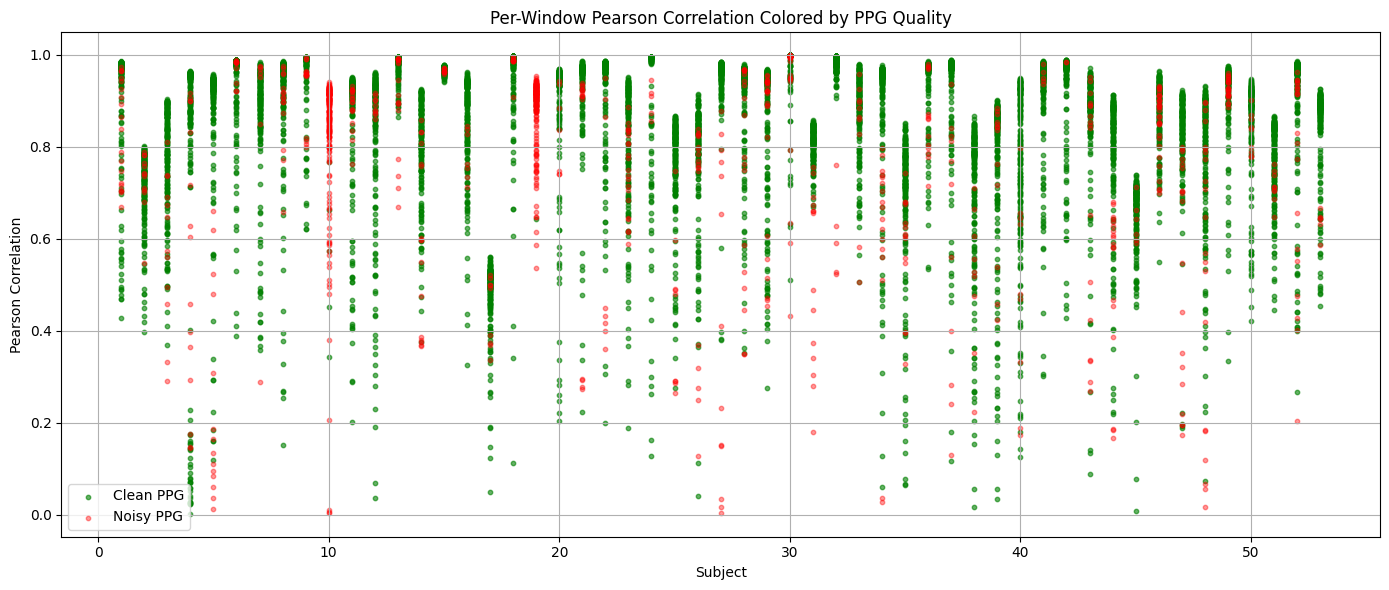

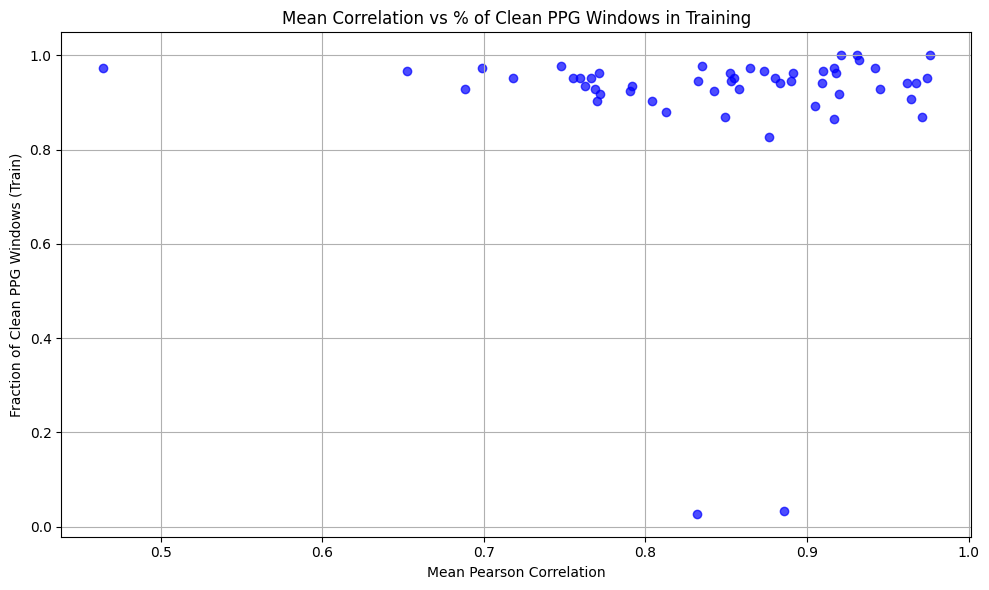

In [14]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from models.ecg2ppg_model import ECG2PPGps, create_windows
from utils.eval_metrics import compute_pearson

# Parameters
FS = 125
WINDOW_SIZE_SEC = 8.192
STEP_SIZE_SEC = 2.048
window_length = 1024
stride = 256
batch_size = 128
DATA_DIR = "bidmc_csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_sqi_snr(w): 
    return 10 * np.log10(np.var(np.abs(w)) / (np.var(w) + 1e-8))
def compute_sqi_kur(w): 
    return kurtosis(w)
def compute_sqi_skew(w): 
    return skew(w)

# Clustering function
def cluster_signal_windows(signal, fs, window_size_sec=8.192, step_size_sec=2.048, eps=0.8, min_samples=5):
    win_size = int(window_size_sec * fs)
    step_size = int(step_size_sec * fs)
    window_ranges = [(start, start + win_size) for start in range(0, len(signal) - win_size + 1, step_size)]
    if not window_ranges:
        return np.array([])

    windows = [signal[start:end] for start, end in window_ranges]
    sqi_data = [[compute_sqi_snr(w), compute_sqi_kur(w), compute_sqi_skew(w)] for w in windows]
    df_sqi = pd.DataFrame(sqi_data, columns=["SQIsnr", "SQIkur", "SQIskew"]).dropna()
    if df_sqi.empty: return np.array([])

    X_scaled = StandardScaler().fit_transform(df_sqi)
    raw_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_scaled)
    return np.where(raw_labels == 0, 0, 1)

# Evaluation loop
N_SUBJECTS = 53
eval_plot_data = []
subject_summary = []

for subject_id in range(1, N_SUBJECTS + 1):
    model_path = f"subject_models/subject_{subject_id:02d}_model.pth"
    signal_path = f"{DATA_DIR}/bidmc_{subject_id:02d}_Signals.csv"
    if not os.path.exists(model_path) or not os.path.exists(signal_path):
        continue

    df = pd.read_csv(signal_path)
    df.columns = [c.strip() for c in df.columns]
    if 'II' not in df.columns or 'PLETH' not in df.columns:
        continue

    ecg = df['II'].to_numpy()
    ecg = remove_baseline_wavelet(ecg)  
    ppg = df['PLETH'].to_numpy()
    ppg = remove_baseline_median(ppg, fs)

    ecg_labels = cluster_signal_windows(ecg, FS, WINDOW_SIZE_SEC, STEP_SIZE_SEC)
    ppg_labels = cluster_signal_windows(ppg, FS, WINDOW_SIZE_SEC, STEP_SIZE_SEC)

    ecg_windows = create_windows(ecg, window_length, stride)
    ppg_windows = create_windows(ppg, window_length, stride)

    N = min(len(ecg_windows), len(ppg_windows), len(ecg_labels), len(ppg_labels))
    if N == 0: continue

    ecg_windows = ecg_windows[:N]
    ppg_windows = ppg_windows[:N]
    ecg_labels = ecg_labels[:N]
    ppg_labels = ppg_labels[:N]

    model = ECG2PPGps(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    tensor_input = torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1)
    tensor_target = torch.tensor(ecg_windows, dtype=torch.float32).unsqueeze(1)
    loader = DataLoader(TensorDataset(tensor_input, tensor_target), batch_size=batch_size)

    preds, targets = [], []
    with torch.no_grad():
        for batch_input, batch_target in loader:
            output = model(batch_input.to(device)).cpu().squeeze(1).numpy()
            preds.append(output)
            targets.append(batch_target.squeeze(1).numpy())

    preds = np.vstack(preds)
    targets = np.vstack(targets)

    clean_pair_count = np.sum((ecg_labels == 0) & (ppg_labels == 0))
    for i in range(N):
        pearson = compute_pearson(targets[i], preds[i])
        eval_plot_data.append({
            "Subject": subject_id,
            "Window": i,
            "Pearson_r": pearson,
            "ECG_Clean": ecg_labels[i] == 0,
            "PPG_Clean": ppg_labels[i] == 0
        })

    subject_summary.append({
        "Subject": subject_id,
        "Mean_Pearson_r": np.mean([e["Pearson_r"] for e in eval_plot_data if e["Subject"] == subject_id]),
        "Clean_ECG_PPG_Pairs": clean_pair_count
    })

import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrames if not already
df_plot1 = pd.DataFrame(eval_plot_data)
df_plot2 = pd.DataFrame(subject_summary)

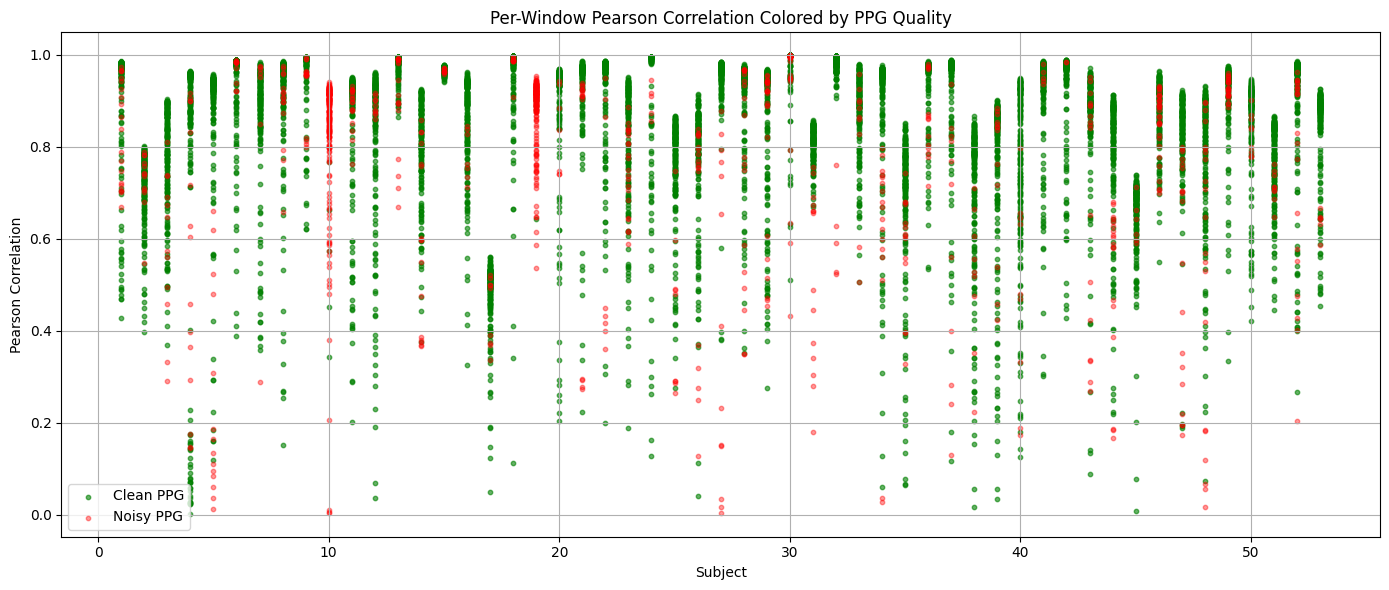

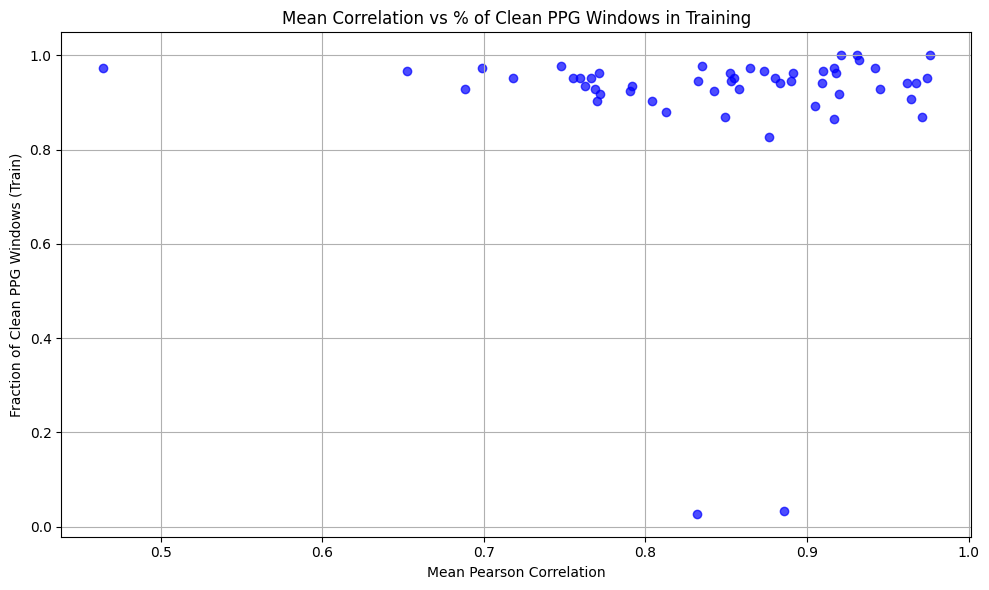

In [18]:
# ----------------------------
# Plot 1: Correlation colored by PPG cleanliness
# ----------------------------
plt.figure(figsize=(14, 6))
plt.scatter(
    df_plot1[df_plot1["PPG_Clean"]]["Subject"],
    abs(df_plot1[df_plot1["PPG_Clean"]]["Pearson_r"]),
    color="green", alpha=0.6, s=10, label="Clean PPG"
)
plt.scatter(
    df_plot1[~df_plot1["PPG_Clean"]]["Subject"],
   abs(df_plot1[~df_plot1["PPG_Clean"]]["Pearson_r"]),
    color="red", alpha=0.4, s=10, label="Noisy PPG"
)
plt.title("Per-Window Pearson Correlation Colored by PPG Quality")
plt.xlabel("Subject")
plt.ylabel("Pearson Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Mean correlation vs % clean PPG windows in training
# ----------------------------
train_ratios = []
for subject_id in df_plot2["Subject"]:
    ppg_clean_flags = df_plot1[df_plot1["Subject"] == subject_id]["PPG_Clean"].values
    train_cutoff = int(0.8 * len(ppg_clean_flags))
    if train_cutoff > 0:
        train_ratio = np.sum(ppg_clean_flags[:train_cutoff]) / train_cutoff
    else:
        train_ratio = 0
    train_ratios.append(train_ratio)

df_plot2["Clean_PPG_Train_Ratio"] = train_ratios

plt.figure(figsize=(10, 6))
plt.scatter(
    abs(df_plot2["Mean_Pearson_r"]),
    df_plot2["Clean_PPG_Train_Ratio"],
    color='blue', alpha=0.7
)
plt.title("Mean Correlation vs % of Clean PPG Windows in Training")
plt.xlabel("Mean Pearson Correlation")
plt.ylabel("Fraction of Clean PPG Windows (Train)")
plt.grid(True)
plt.tight_layout()
plt.show()


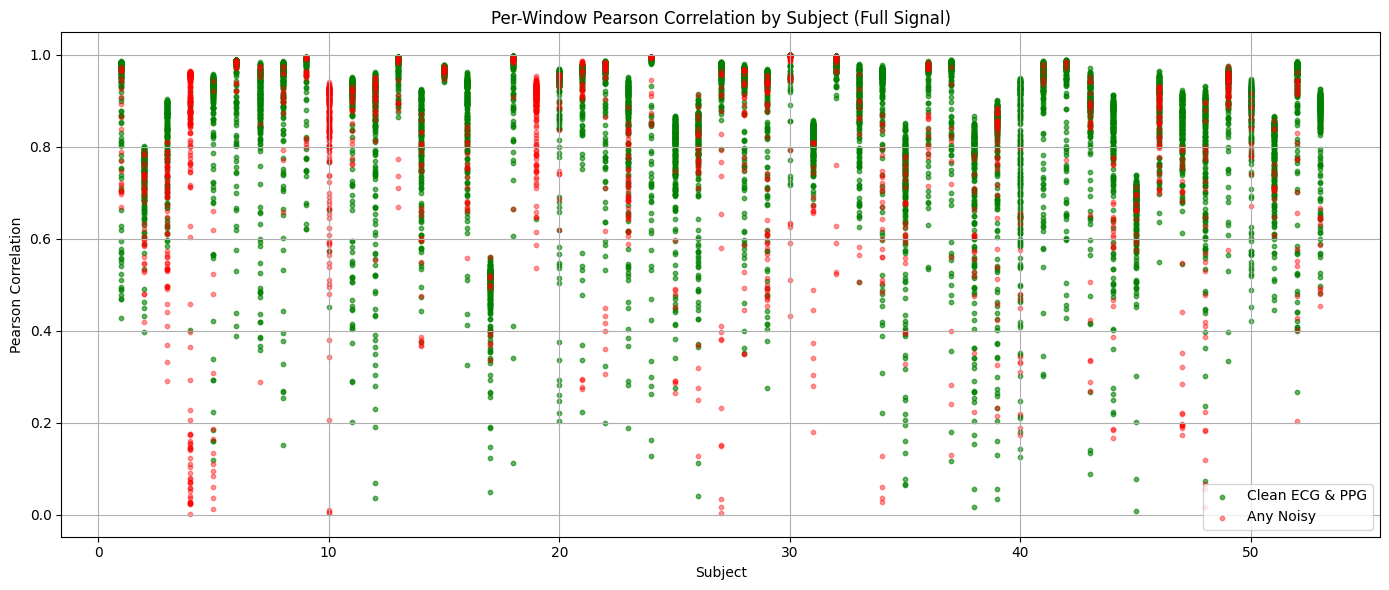

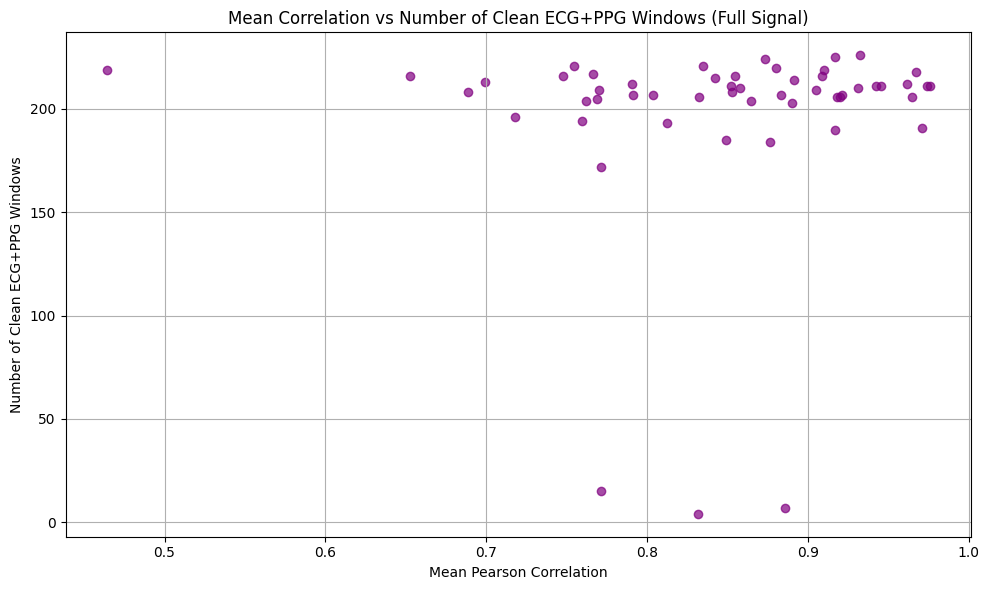

In [17]:
f_plot1 = pd.DataFrame(eval_plot_data)
df_plot1["CleanPair"] = df_plot1["ECG_Clean"] & df_plot1["PPG_Clean"]

plt.figure(figsize=(14, 6))
plt.scatter(df_plot1[df_plot1["CleanPair"]]["Subject"], abs(df_plot1[df_plot1["CleanPair"]]["Pearson_r"]),
            color="green", alpha=0.6, s=10, label="Clean ECG & PPG")
plt.scatter(df_plot1[~df_plot1["CleanPair"]]["Subject"], abs(df_plot1[~df_plot1["CleanPair"]]["Pearson_r"]),
            color="red", alpha=0.4, s=10, label="Any Noisy")
plt.title("Per-Window Pearson Correlation by Subject (Full Signal)")
plt.xlabel("Subject")
plt.ylabel("Pearson Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Mean correlation vs # clean windows ---
df_plot2 = pd.DataFrame(subject_summary)
plt.figure(figsize=(10, 6))
plt.scatter(abs(df_plot2["Mean_Pearson_r"]), df_plot2["Clean_ECG_PPG_Pairs"],
            color='purple', alpha=0.7)
plt.title("Mean Correlation vs Number of Clean ECG+PPG Windows (Full Signal)")
plt.xlabel("Mean Pearson Correlation")
plt.ylabel("Number of Clean ECG+PPG Windows")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, pearsonr

# Prepare DataFrame
df = pd.DataFrame(eval_plot_data)
df["PPG_Clean_Int"] = df["PPG_Clean"].astype(int)
df["ECG_Clean_Int"] = df["ECG_Clean"].astype(int)

# --- Point-Biserial Correlations ---
r_ppg, pval_ppg = pointbiserialr(df["PPG_Clean_Int"], df["Pearson_r"])
r_ecg, pval_ecg = pointbiserialr(df["ECG_Clean_Int"], df["Pearson_r"])

print(f"🔹 Correlation (PPG Clean vs Pearson_r): r = {r_ppg:.4f}, p = {pval_ppg:.4e}")
print(f"🔹 Correlation (ECG Clean vs Pearson_r): r = {r_ecg:.4f}, p = {pval_ecg:.4e}")

# --- Multiple Linear Regression (with numpy) ---
X = df[["PPG_Clean_Int", "ECG_Clean_Int"]].values
X = np.column_stack([np.ones(len(X)), X])  # add intercept
y = df["Pearson_r"].values

# Solve for β using least squares: β = (XᵀX)^(-1) Xᵀy
beta = np.linalg.inv(X.T @ X) @ X.T @ y

# Predict values and compute R²
y_pred = X @ beta
residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - ss_res / ss_tot

print(f"\n🔹 Multiple Linear Regression Coefficients:")
print(f"Intercept: {beta[0]:.4f}")
print(f"PPG_Clean Coef: {beta[1]:.4f}")
print(f"ECG_Clean Coef: {beta[2]:.4f}")
print(f"R² = {r_squared:.4f}")


🔹 Correlation (PPG Clean vs Pearson_r): r = -0.1449, p = 1.9191e-58
🔹 Correlation (ECG Clean vs Pearson_r): r = -0.1696, p = 1.1280e-79

🔹 Multiple Linear Regression Coefficients:
Intercept: 0.5419
PPG_Clean Coef: -0.3058
ECG_Clean Coef: -0.4305
R² = 0.0389


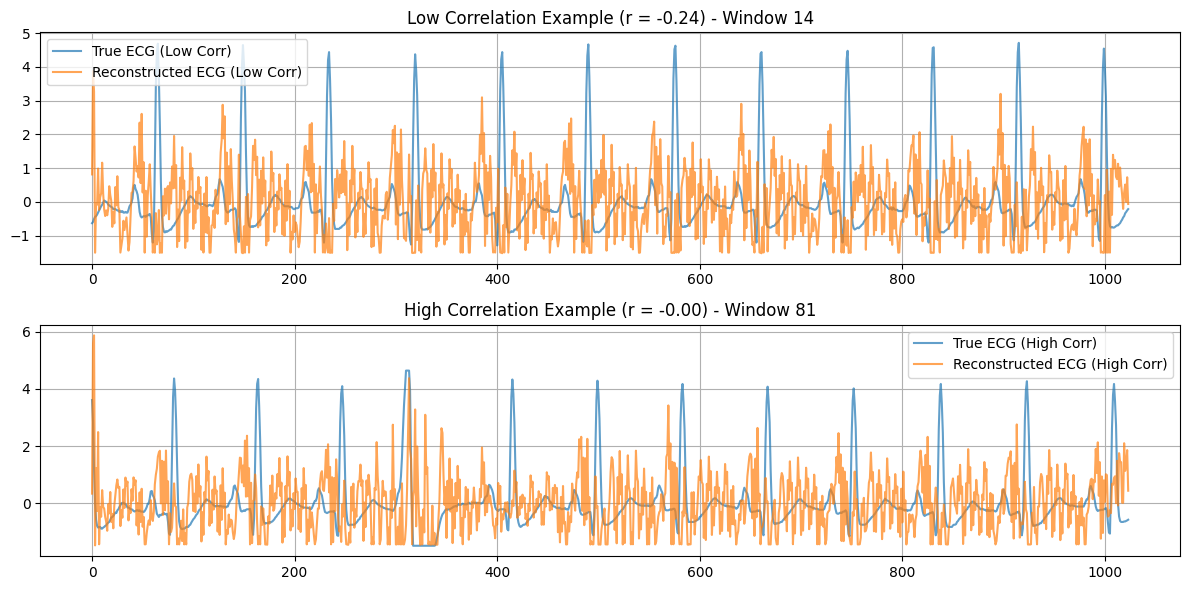

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Compute Pearson correlation per window for subject 1
correlations = []
for i in range(len(ecg_windows)):
    if len(ecg_windows[i]) != 1024 or len(ppg_windows[i]) != 1024:
        continue
    input_tensor = torch.tensor(ppg_windows[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        output = model(input_tensor).squeeze().cpu().numpy()

    recon_norm = (output - np.mean(output)) / np.std(output)
    true_norm = (ecg_windows[i] - np.mean(ecg_windows[i])) / np.std(ecg_windows[i])
    corr = np.corrcoef(recon_norm, true_norm)[0, 1]
    correlations.append((i, corr))

# Sort and get best/worst
correlations.sort(key=lambda x: x[1])
low_corr_idx = correlations[0][0]
high_corr_idx = correlations[-1][0]
low_corr_val = correlations[0][1]
high_corr_val = correlations[-1][1]

# Function to retrieve normalized signals
def get_norm_signals(index):
    input_tensor = torch.tensor(ppg_windows[index:index+1], dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        output = model(input_tensor).squeeze().cpu().numpy()
    recon = (output - np.mean(output)) / np.std(output)
    true = (ecg_windows[index] - np.mean(ecg_windows[index])) / np.std(ecg_windows[index])
    return true, recon

true_low, recon_low = get_norm_signals(low_corr_idx)
true_high, recon_high = get_norm_signals(high_corr_idx)

# Plot both cases
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(true_low, label="True ECG (Low Corr)", alpha=0.7)
axs[0].plot(recon_low, label="Reconstructed ECG (Low Corr)", alpha=0.7)
axs[0].set_title(f"Low Correlation Example (r = {low_corr_val:.2f}) - Window {low_corr_idx}")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(true_high, label="True ECG (High Corr)", alpha=0.7)
axs[1].plot(recon_high, label="Reconstructed ECG (High Corr)", alpha=0.7)
axs[1].set_title(f"High Correlation Example (r = {high_corr_val:.2f}) - Window {high_corr_idx}")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


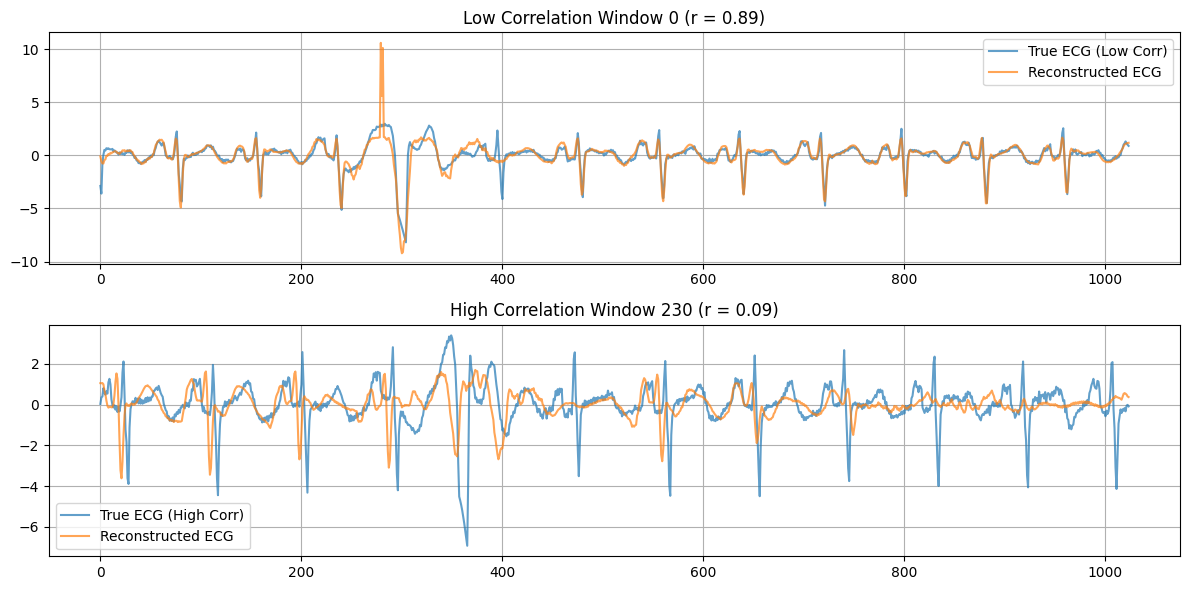

In [38]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt
from models.ecg2ppg_model import ECG2PPGps, create_windows

# --- Parameters ---
FS = 125
window_length = 1024
stride = 256
DATA_DIR = "bidmc_csv"
subject_id = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Baseline Removal Functions ---
def remove_baseline_median(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def remove_baseline_wavelet(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    return pywt.waverec(coeffs, wavelet)[:len(signal)]

# --- Load and preprocess data ---
file_path = os.path.join(DATA_DIR, f"bidmc_{subject_id:02d}_Signals.csv")
df = pd.read_csv(file_path)
df.columns = [c.strip() for c in df.columns]
ecg = df['II'].values
ppg = df['PLETH'].values

# Remove baseline
ecg_clean = remove_baseline_wavelet(ecg)
ppg_clean = remove_baseline_median(ppg, FS)

# Window signals
ecg_windows = create_windows(ecg_clean, window_length, stride)
ppg_windows = create_windows(ppg_clean, window_length, stride)

# --- Load model ---
model = ECG2PPGps(in_channels=1, out_channels=1).to(device)
model_path = f"subject_models/subject_{subject_id:02d}_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Run model on all windows ---
input_tensor = torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1).to(device)
with torch.no_grad():
    recon_windows = model(input_tensor).squeeze(1).cpu().numpy()

# --- Stitch reconstructed signal ---
reconstructed = np.zeros_like(ecg_clean)
counts = np.zeros_like(ecg_clean)

for i, win in enumerate(recon_windows):
    start = i * stride
    end = start + window_length
    reconstructed[start:end] += win[:len(reconstructed[start:end])]
    counts[start:end] += 1

counts[counts == 0] = 1
reconstructed /= counts

# --- Normalize full signals ---
ecg_norm = (ecg_clean - np.mean(ecg_clean)) / np.std(ecg_clean)
reconstructed_norm = (reconstructed - np.mean(reconstructed)) / np.std(reconstructed)

# --- Plot full signals ---
from utils.eval_metrics import compute_pearson

# Re-window normalized signals
ecg_windows_norm = create_windows(ecg_norm, window_length, stride)
recon_windows_norm = create_windows(reconstructed_norm, window_length, stride)

# Compute correlation per window
corrs = []
for i in range(len(ecg_windows_norm)):
    r = compute_pearson(ecg_windows_norm[i], recon_windows_norm[i])
    corrs.append((i, r))


low_idx, low_val = corrs[0]
high_idx, high_val = corrs[-1]

# Plot low and high correlation windows
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(ecg_windows_norm[low_idx], label="True ECG (Low Corr)", alpha=0.7)
axs[0].plot(recon_windows_norm[low_idx], label="Reconstructed ECG", alpha=0.7)
axs[0].set_title(f"Low Correlation Window {low_idx} (r = {abs(low_val):.2f})")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(ecg_windows_norm[high_idx], label="True ECG (High Corr)", alpha=0.7)
axs[1].plot(recon_windows_norm[high_idx], label="Reconstructed ECG", alpha=0.7)
axs[1].set_title(f"High Correlation Window {high_idx} (r = {abs(high_val):.2f})")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



In [43]:
import os
import pandas as pd
import numpy as np

eval_dir = "reconstruction_weights_bidmc"
subject_ids = range(1, 54)
all_corrs = []

for sid in subject_ids:
    file_name = f"subject_{sid:02d}_evaluation.csv"
    file_path = os.path.join(eval_dir, file_name)
    
    if not os.path.exists(file_path):
        print(f"{file_name} not found.")
        continue
    
    df = pd.read_csv(file_path)
    if "Pearson_r" not in df.columns:
        print(f"{file_name} missing 'Pearson_r' column.")
        continue
    
    corrs = df["Pearson_r"].dropna().values
    if len(corrs) == 0:
        print(f"{file_name} has no non-NaN Pearson_r values.")
    else:
        print(f"{file_name} has {len(corrs)} valid Pearson_r values.")
        all_corrs.extend(corrs)

print("\n--- Summary ---")
print(f"Total non-NaN Pearson_r values collected: {len(all_corrs)}")
if len(all_corrs) > 0:
    print(f"Mean correlation: {np.mean(all_corrs):.4f}")
    print(f"Median correlation: {np.median(all_corrs):.4f}")
else:
    print("No valid Pearson_r values found.")


subject_01_evaluation.csv has 47 valid Pearson_r values.
subject_02_evaluation.csv has 47 valid Pearson_r values.
subject_03_evaluation.csv has 47 valid Pearson_r values.
subject_04_evaluation.csv has 47 valid Pearson_r values.
subject_05_evaluation.csv has 47 valid Pearson_r values.
subject_06_evaluation.csv has 47 valid Pearson_r values.
subject_07_evaluation.csv has 47 valid Pearson_r values.
subject_08_evaluation.csv has 47 valid Pearson_r values.
subject_09_evaluation.csv has 47 valid Pearson_r values.
subject_10_evaluation.csv has 47 valid Pearson_r values.
subject_11_evaluation.csv has 47 valid Pearson_r values.
subject_12_evaluation.csv has 47 valid Pearson_r values.
subject_13_evaluation.csv has 47 valid Pearson_r values.
subject_14_evaluation.csv has 47 valid Pearson_r values.
subject_15_evaluation.csv has 47 valid Pearson_r values.
subject_16_evaluation.csv has 47 valid Pearson_r values.
subject_17_evaluation.csv has 47 valid Pearson_r values.
subject_18_evaluation.csv has 4